In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('input/train.csv')

In [3]:
num = [x for x in df.columns if df.dtypes[x] in ('float', 'int64')]
cat = [x for x in df.columns if df.dtypes[x] == 'object']
target = 'SalePrice'
num.remove(target)

In [4]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=0)

# Explore

In [5]:
corr = train.corr(numeric_only=True)
corr[target].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790636
GrLivArea        0.721707
GarageCars       0.660927
GarageArea       0.646603
TotalBsmtSF      0.635535
1stFlrSF         0.620740
FullBath         0.578134
TotRmsAbvGrd     0.542658
YearBuilt        0.521242
YearRemodAdd     0.517822
GarageYrBlt      0.494154
MasVnrArea       0.493482
Fireplaces       0.470320
BsmtFinSF1       0.401390
LotFrontage      0.360274
OpenPorchSF      0.320193
2ndFlrSF         0.320141
WoodDeckSF       0.311813
HalfBath         0.283762
LotArea          0.252766
BsmtFullBath     0.226432
BsmtUnfSF        0.206736
BedroomAbvGr     0.182258
ScreenPorch      0.096740
3SsnPorch        0.057561
MoSold           0.041369
PoolArea         0.027441
BsmtHalfBath    -0.010994
Id              -0.017389
BsmtFinSF2      -0.020622
LowQualFinSF    -0.023128
MiscVal         -0.024750
YrSold          -0.045628
OverallCond     -0.053643
MSSubClass      -0.084312
EnclosedPorch   -0.129519
KitchenAbvGr    -0.136104
Name: SalePr

# Pipeline

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer

In [24]:
num_pk = [x for x in num if x not in ('Id')]
cat_pk = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond'
          , 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'
          , 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

blu = {
    'ExterQual': {'key': ['Ex','Gd','TA','Fa','Po'], 'val': [5,4,3,2,1]}
    , 'ExterCond': {'key': ['Ex','Gd','TA','Fa','Po'], 'val': [5,4,3,2,1]}
    , 'BsmtQual': {'key': ['Ex','Gd','TA','Fa','Po'], 'val': [5,4,3,2,1]}
    , 'BsmtCond': {'key': ['Ex','Gd','TA','Fa','Po'], 'val': [5,4,3,2,1]}
    , 'BsmtExposure': {'key': ['Gd','Av','Mn','No'], 'val': [3,2,1,0]}
    , 'BsmtFinType1': {'key': ['GLQ','ALQ','BLQ','Rec','LWQ','Unf'], 'val': [6,5,4,3,2,0]}
    , 'BsmtFinType2': {'key': ['GLQ','ALQ','BLQ','Rec','LWQ','Unf'], 'val': [6,5,4,3,2,0]}
    , 'HeatingQC': {'key': ['Ex','Gd','TA','Fa','Po'], 'val': [5,4,3,2,1]}
    , 'KitchenQual': {'key': ['Ex','Gd','TA','Fa','Po'], 'val': [5,4,3,2,1]}
    , 'FireplaceQu': {'key': ['Ex','Gd','TA','Fa','Po'], 'val': [5,4,3,2,1]}
    , 'GarageQual': {'key': ['Ex','Gd','TA','Fa','Po'], 'val': [5,4,3,2,1]}
    , 'GarageCond': {'key': ['Ex','Gd','TA','Fa','Po'], 'val': [5,4,3,2,1]}
    , 'PoolQC': {'key': ['Ex','Gd','TA','Fa','Po'], 'val': [5,4,3,2,1]}
}

In [25]:
class DataSelect(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attributes]

In [26]:
class CustomEncode(BaseEstimator, TransformerMixin):
    def __init__(self, led):
        self.led = led
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        dat = {}
        for itm in self.led:
            dat['y_'+itm] = X[itm].map({x:y for x,y in zip(self.led[itm]['key']
                                                               , self.led[itm]['val'])})
        return pd.DataFrame(dat).fillna(0)

In [30]:
num_pp = Pipeline([
    ('dataselect', DataSelect(num_pk))
    , ('impute', SimpleImputer(strategy='median'))
    , ('scaler', StandardScaler())
    , ('poly', PolynomialFeatures())
])

cat_pp = Pipeline([
    ('dataselect', DataSelect(cat_pk))
#     , ('encode', OneHotEncoder(sparse_output=False))
    , ('customencode', CustomEncode(blu))
    , ('scaler', StandardScaler())
    , ('poly', PolynomialFeatures())
])

pipe = FeatureUnion([
    ('num', num_pp)
    , ('cat', cat_pp)
])

pipe.fit(train)
train_pre = pipe.transform(train)
test_pre = pipe.transform(test)

# Model Select

In [31]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score

In [32]:
lin_reg = LinearRegression()
lin_reg.fit(train_pre, train[target])
np.sqrt(-cross_val_score(lin_reg, train_pre, train[target], scoring='neg_mean_squared_error').mean())

6620014191976436.0

In [33]:
rid_reg = Ridge()
rid_reg.fit(train_pre, train[target])
np.sqrt(-cross_val_score(rid_reg, train_pre, train[target], scoring='neg_mean_squared_error').mean())

84968.99106354543

In [34]:
ela_reg = ElasticNet(max_iter=5000)
ela_reg.fit(train_pre, train[target])
np.sqrt(-cross_val_score(ela_reg, train_pre, train[target], scoring='neg_mean_squared_error').mean())

38734.64148026701

In [35]:
model_base = ela_reg

In [36]:
model_base.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 5000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

# Model Tune

In [37]:
from sklearn.model_selection import GridSearchCV
params = {
    'random_state': [0]
    , 'max_iter': [5000]
    , 'alpha': np.arange(0.1, 1.0, 0.1)
}
grid = GridSearchCV(ela_reg, param_grid=params, scoring='neg_mean_squared_error')
grid.fit(train_pre, train[target]);

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.500e+10, tolerance: 5.798e+08
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.968e+10, tolerance: 5.678e+08
  model = cd_fast.enet_coordinate_descent(


In [38]:
grid.best_params_

{'alpha': 0.9, 'max_iter': 5000, 'random_state': 0}

In [39]:
model_tune = ElasticNet(alpha=0.9, max_iter=5000)
model_tune.fit(train_pre, train[target]);

# Validation

In [40]:
print(
np.sqrt(-cross_val_score(model_base, train_pre, train[target], scoring='neg_mean_squared_error').mean())
, np.sqrt(-cross_val_score(model_base, test_pre, test[target], scoring='neg_mean_squared_error').mean())
)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.840e+10, tolerance: 1.346e+08
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.322e+10, tolerance: 1.776e+08
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.228e+10, toleranc

38734.64148026701 120869.80502809283


In [41]:
print(
np.sqrt(-cross_val_score(model_tune, train_pre, train[target], scoring='neg_mean_squared_error').mean())
, np.sqrt(-cross_val_score(model_tune, test_pre, test[target], scoring='neg_mean_squared_error').mean())
)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.617e+10, tolerance: 1.346e+08
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.092e+10, tolerance: 1.776e+08
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.003e+10, toleranc

38902.687815586374 121451.99296910067


# Residual Analysis

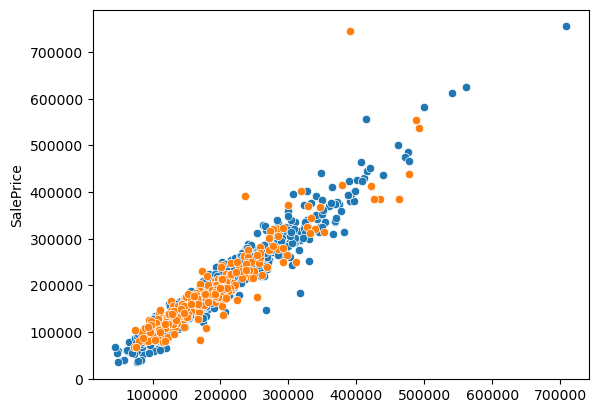

In [42]:
X = model_tune.predict(train_pre)
Y = train[target]

Xhat = model_tune.predict(test_pre)
Yhat = test[target]
sns.scatterplot(x=X, y=Y);
sns.scatterplot(x=Xhat, y=Yhat);

In [43]:
import matplotlib.pyplot as plt

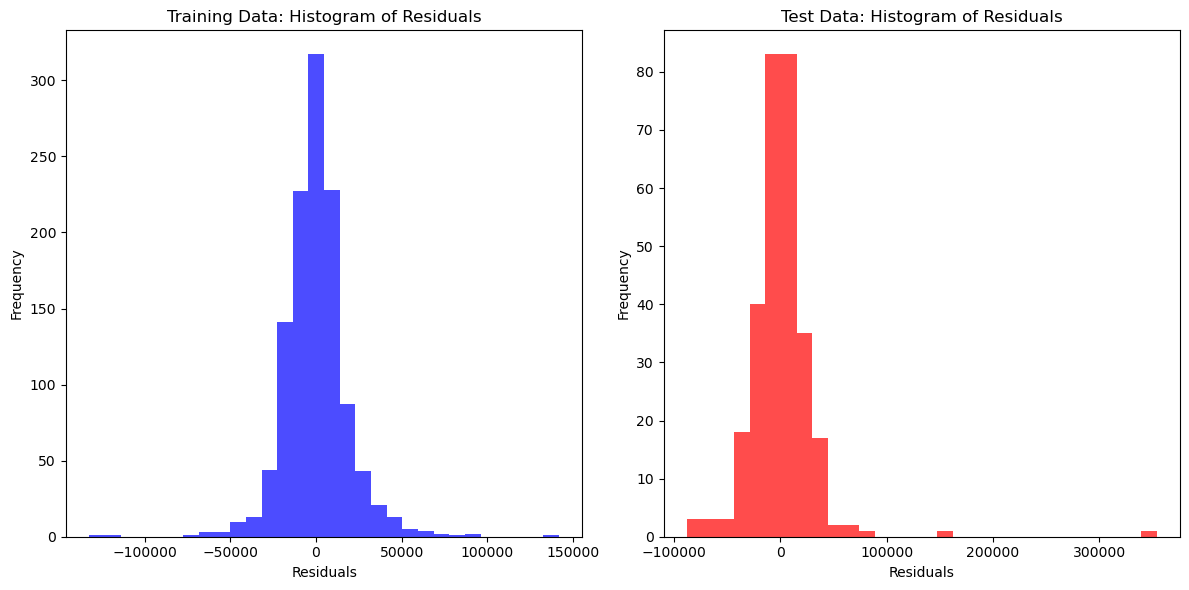

In [44]:
# Calculate residuals for both training and test data
train_residuals = Y - X
test_residuals = Yhat - Xhat

# Create histograms of residuals
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(train_residuals, bins=30, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Training Data: Histogram of Residuals')

plt.subplot(1, 2, 2)
plt.hist(test_residuals, bins=30, color='red', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Test Data: Histogram of Residuals')

plt.tight_layout()
plt.show()
